In [1]:
%load_ext autoreload
%autoreload 2

import plotter
import analysis
import lmpsetup

import numpy as np
import matplotlib.pyplot as plt
import analysis

## Summary

This week is mainly a "testing" week, where we want to review different techniques used by other that are to be used in the future :

**[1. Charge effect maximization](#1)** : From last week, even in HPS-T it seems that differences, at least in single chain which can easily propagate to multi-chain, are minimal, and so a reduction in hydrophobicity strength is required. The idea is to test whether the minimization-reweighting algorithm used before is enough.

**[2. HOOMD Build](#2)** 

### 1. Charge effect maximization <a id='1'></a>

Recall that for a single chain, our constructs' radius of gyration where **almost equal** at all temperatures :

In [3]:
p = plotter.Plotter(data_dir='/home/adria/perdiux/prod/lammps/dignon')

> Run Completed at 21.91% for 12D_CPEB4_D4. Ran 219050000 steps for a total of 43811 frames 
> Taking frames every 2 for a total of 10000 to avoid strong correlations
(7, 10000)
> Run Completed at 14.38% for 7D_CPEB4. Ran 143805000 steps for a total of 28762 frames 
> Taking frames every 2 for a total of 10000 to avoid strong correlations
(7, 10000)
> Run Completed at 31.77% for CPEB4. Ran 317695000 steps for a total of 63540 frames 
> Taking frames every 2 for a total of 10000 to avoid strong correlations
(7, 10000)
> Run Completed at 38.98% for CPEB4_D4. Ran 389850000 steps for a total of 77971 frames 
> Taking frames every 2 for a total of 10000 to avoid strong correlations
(7, 10000)


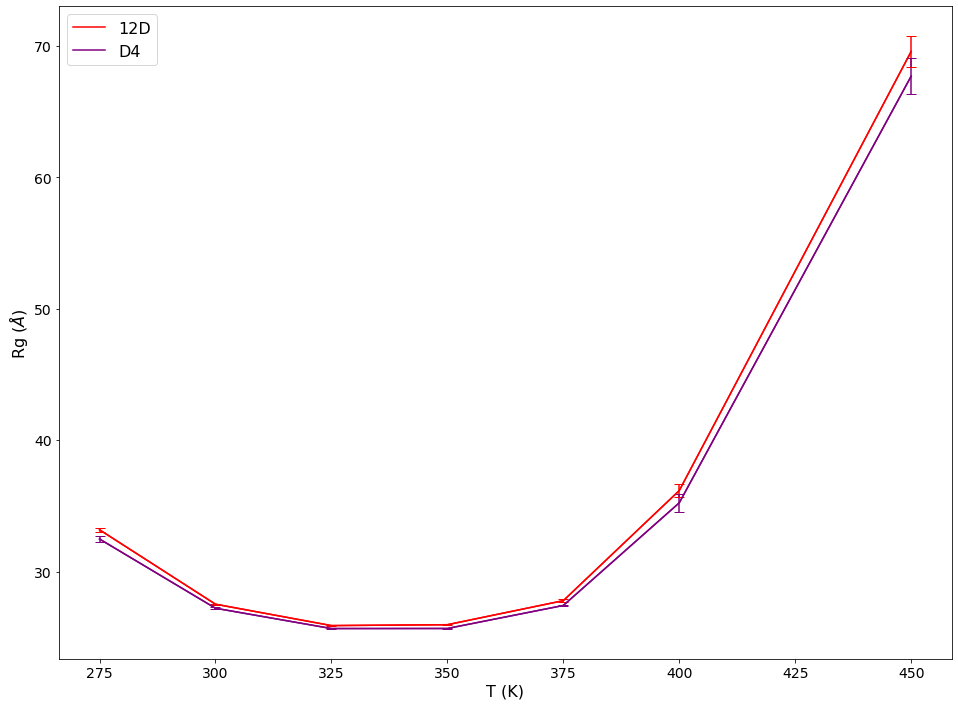

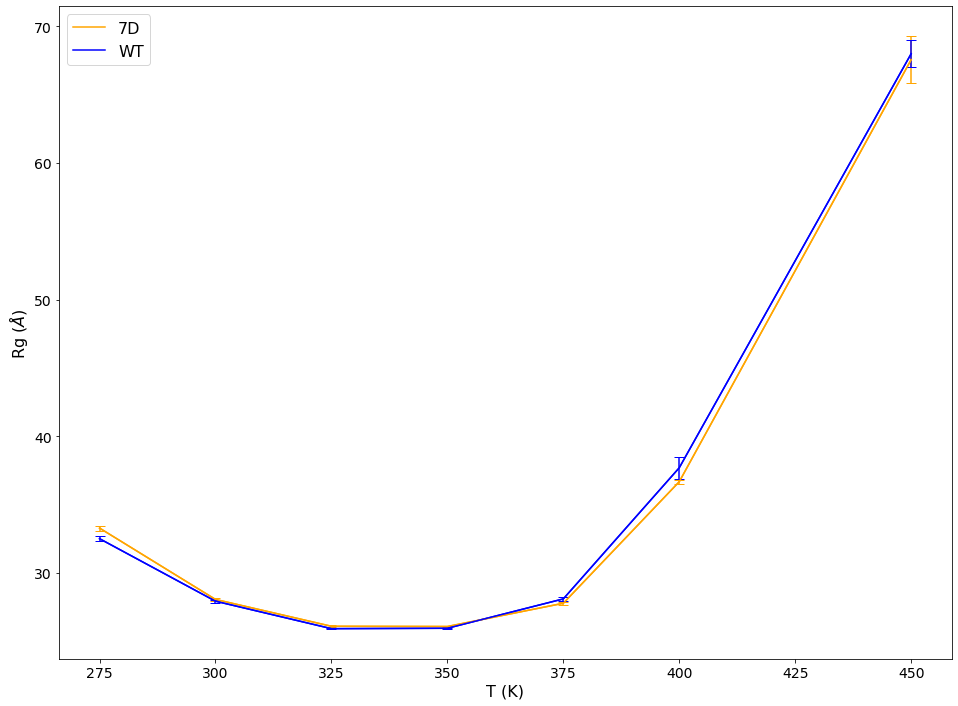

In [4]:
rg = p.plot(observable='rg', index=22, plot_id='d4', label='12D', color='red')
rg = p.plot(observable='rg', index=24, plot_id='wt', label='7D', color='orange')
rg = p.plot(observable='rg', index=26, plot_id='wt', label='WT', color='blue')
rg = p.plot(observable='rg', index=27, plot_id='d4', label='D4', color='purple')

Let's attempt the minimization !

In [16]:
path_12D = p.index.iloc[22]["FullPath"]
path_D4 = p.index.iloc[27]["FullPath"]

maxx = analysis.Analysis(oliba_wd=None)
maxx.maximize_charge(a_dir=path_12D, b_dir=path_D4, l0=0.97, T=2)

It actually fails since the box is too small...

### 2. HOOMD build <a id='2'></a>

### 3. Slab Method <a id='3'></a>

#### Chan's slab

*We begin each simulation by randomly placing n = 500 IDP chains in a periodic cubic
simulation box of length 70a. Subsequently, the chain configurations are energy-minimized
and then heated to a high T
∗ = 4.0 for 5, 000τ . This is followed by a compression of the
periodic simulation box (by isotropic rescaling of all chain coordinates) at a constant rate
under the same high T
∗ = 4.0 for 10, 000τ to arrive at a much smaller periodic cubic box
of length 33a, resulting in a final IDP density ρ ≈ 0.7m/a3
. The simulation box is then
expanded along the direction (labeled as z) of one of the three axes of the box by a factor
of eight with the temperature kept at a low T
∗ = 1.0, resulting in a simulation box with
dimensions 33a × 33a × 264a containing a concentration of chain population (a “slab”)
somewhere along the z-axis whereas chain population is zero or extremely sparse for other
parts of the elongated simulation box. Any conformation that is originally wrapped in the zdirection in the compressed 33a×33a×33a box because of the periodic boundary conditions
is unwrapped in this expansion process by placing the chain conformation entirely on the
side of the “slab” with larger z values (see Fig. 1 for a visualization129 of this procedure).*

In [80]:
s = lmpsetup.LMPSetup(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/SLAB-TEST/CHAN',
                      use_random=True,
                      protein='CPEB4',
                      temperatures=[300],
                      chains=50,
                      slab=True,
                      save=5000,
                      t=100000000,
                      temper=False)
s.processors = 4
s.write_hps_files(silent=True)

In [5]:
chan_s = analysis.Analysis(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/SLAB-TEST/CHAN', equil_frames=0)
chan_s.save_movies(frames='all')

> Run Completed at 100.00% for CPEB4. Ran 10000 steps for a total of 3 frames 
> Taking frames every 1 for a total of 1000 to avoid strong correlations


My main mistake was taking CHan's description too literal, and my slab expansion was followed by a remap of the x coordinates. This is obviously what we don't want to achieve, therefore we must disable remapping !!

<img src='img/slab_test.gif' width=300> 

It seems then that we might be ready to simulate droplets for our constructs !

In [18]:
wt = lmpsetup.LMPSetup(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/CPEB4x50', 
                      protein='CPEB4', 
                      temper=False, 
                      chains=50, 
                      host='@perdiu42',
                      model='HPS-T',
                      debye=0.1,
                      use_random=True,
                      slab=True,
                      save=5000)
wt.temperatures = [275, 300, 325, 350, 375, 400, 450]
wt.processors = 2
wt.t = 1000000000
wt.write_hps_files(silent=True)

In [19]:
d12 = lmpsetup.LMPSetup(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/12D_CPEB4_D4x50', 
                       protein='12D_CPEB4_D4', 
                       temper=False, 
                       chains=50, 
                       model='HPS-T',
                       host='@perdiu38',
                       debye=0.1,
                       use_random=True,
                       slab=True,
                       save=5000)
d12.temperatures = [275, 300, 325, 350, 375, 400, 450]
d12.processors = 2
d12.t = 1000000000
d12.write_hps_files(silent=True)

In [20]:
d7 = lmpsetup.LMPSetup(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/7D_CPEB4x50', 
                      protein='7D_CPEB4', 
                      temper=False, 
                      chains=50, 
                      model='HPS-T',
                      host='@perdiu39',
                      slab=True,
                      debye=0.1,
                      use_random=True, 
                      save=5000)
d7.temperatures = [275, 300, 325, 350, 375, 400, 450]
d7.processors = 2
d7.t = 1000000000
d7.write_hps_files(silent=True)

In [21]:
d4 = lmpsetup.LMPSetup(oliba_wd='/home/adria/perdiux/prod/lammps/dignon/HPS-T/CPEB4_D4x50', 
                      protein='CPEB4_D4', 
                      temper=False, 
                      chains=50, 
                      model='HPS-T',
                      host='@perdiu43',
                      debye=0.1,
                      slab=True,
                      use_random=True, 
                      save=5000)
d4.temperatures = [275, 300, 325, 350, 375, 400, 450]
d4.processors = 2
d4.t = 1000000000
d4.write_hps_files(silent=True)